<a href="https://colab.research.google.com/github/pgordin/GraphsSN2025/blob/main/Graphs6a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Graphs & Social Networks &mdash; lab material
This notebook contains a definition of a python class *Graph*, containing functions described during labs.

Package import.

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [17]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Class *Graph*

In [18]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self):
      """
      Plots the graph using methods from networkx package.
      """
      G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()


    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v):
        """
        Print vertices of a tree in preorder, starting from vertex v.
        """
        order = []

        def DFS(u, parent=None):
            order.append(u)
            for w in sorted(self.graph.get(u, [])):
                if w != parent:
                    DFS(w, u)

        DFS(v)
        return " ".join(map(str, order))


    def postorder(self, v):
        """
        Print vertices of a tree in postorder, starting from vertex v.
        """
        visited = set()
        order = []

        def DFS(u):
            visited.add(u)
            for w in sorted(self.graph.get(u, [])):
                if w not in visited:
                    DFS(w)
            order.append(u)

        DFS(v)
        return " ".join(map(str, order))


    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by a set of vertices V.
        """
        sub_dict = {v: [w for w in self.graph[v] if w in V] for v in V}
        subgraph = Graph.from_dict(sub_dict)
        return subgraph

    def ConnectedComponentsGraphs(self):
        """
        Returns a list of Graph objects, each corresponding to one connected component.
        """
        VT = self.connected_components()
        components = []

        for i, vertex_set in enumerate(VT[1:], start=1):
            sub_dict = {
                v: self.graph[v]
                for v in vertex_set
            }
            subgraph = Graph.from_dict(sub_dict)
            components.append(subgraph)

            #print(f"Connected Component {i}:")
            #print(subgraph)

        return components

    def distance(self, v):
      """
      Computes the distance from vertex v to each vertex reachable from it.
      It uses a BFS approach.
      Result is given as a dictionary of distances.
      """
      dist = {v: 0}   # starting point of a dictionary
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    def ConnectedComponentsBFS(self):
        """
        Determines connected components using Breadth-First Search (Iterative).
        This is useful for large graphs where recursion depth is an issue.
        """
        VT = [set([])]
        for v in self.graph:
            if v not in VT[0]:
                component = set([v])
                VT[0].add(v)
                queue = [v]
                while len(queue) > 0:
                    u = queue.pop(0)
                    for w in self.graph[u]:
                        if w not in VT[0]:
                            VT[0].add(w)
                            component.add(w)
                            queue.append(w)
                VT.append(component)
        return VT

    # --- TASK 1: Strongly Connected Components (Kosaraju's Algorithm) ---
    def get_transpose(self):
        """Returns the transpose of the graph (all arcs reversed)."""
        g_t = Graph()
        # Ensure all vertices exist in transpose
        for v in self.graph:
            g_t.add_vertex(v)
        # Reverse edges
        for u in self.graph:
            for v in self.graph[u]:
                g_t.add_arc([v, u])
        return g_t

    def StronglyConnectedComponents(self):
        """
        Returns a list of strongly connected components of a digraph.
        Uses Kosaraju's algorithm based on topological sorting logic.
        """
        stack = []
        visited = set()

        # Step 1: Fill stack according to finishing times (Topological Sort)
        def fill_order(u):
            visited.add(u)
            for v in self.graph.get(u, []):
                if v not in visited:
                    fill_order(v)
            stack.append(u)

        for v in self.graph:
            if v not in visited:
                fill_order(v)

        # Step 2: Get transpose of the graph
        g_t = self.get_transpose()

        # Step 3: DFS on transpose graph using stack order
        visited.clear()
        sccs = []

        def dfs_util(u, current_component):
            visited.add(u)
            current_component.append(u)
            for v in g_t.graph.get(u, []):
                if v not in visited:
                    dfs_util(v, current_component)

        while stack:
            u = stack.pop()
            if u not in visited:
                component = []
                dfs_util(u, component)
                sccs.append(component)

        return sccs

    def floyd_warshall(self):
        """
        Calculates shortest paths between all pairs of vertices using the
        Floyd-Warshall algorithm. Assumes unweighted edges (distance=1).
        """
        vertices = self.vertices()
        n = len(vertices)
        v_map = {v: i for i, v in enumerate(vertices)}

        # Initialize matrix with Infinity
        dist = np.full((n, n), np.inf)
        np.fill_diagonal(dist, 0)

        for u in self.graph:
            for v in self.graph[u]:
                dist[v_map[u]][v_map[v]] = 1

        # Main loop
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
        return dist

    def TopologicalSort(self):
        """
        Performs topological sorting of a directed graph using Kahn's Algorithm.
        """
        in_degree = {v: 0 for v in self.graph}
        for u in self.graph:
            for v in self.graph[u]:
                if v not in in_degree: in_degree[v] = 0
                in_degree[v] += 1

        # Queue for vertices with in-degree 0
        queue = [v for v in in_degree if in_degree[v] == 0]
        topo_order = []

        while len(queue) > 0:
            u = queue.pop(0)
            topo_order.append(u)

            for v in self.graph[u]:
                in_degree[v] -= 1
                if in_degree[v] == 0:
                    queue.append(v)

        if len(topo_order) != len(in_degree):
            raise ValueError("Graph has a cycle! Topological sort not possible.")

        return topo_order

## Class *WeightedGraph*

In [19]:
class WeightedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # redefinition of printing
    def __str__(self):
        res = super().__str__()
        res += "------------------------\n"
        for v in self.graph:
          res += f"{v}: "
          for u in self.graph[v]:
            res += f"{u}({self.weights[(v, u)]}) "
          res += "\n"
        return res

    # Modyfying graphs
    def del_vertex(self, vertex):
      """
      Removes a vertex from the graph
      """
      # TODO - should be done in a different way
      super().del_vertex(vertex)


    def add_arc(self, arc, weight = 1):
      """
      Given pair of vertices (arc variable) add an arc to the graph
      We consider simple, directed graphs.
      """
      super().add_arc(arc)
      u, v = arc
      self.weights[(u, v)] = weight

    def add_edge(self, edge, weight = 1):
      """
      Given pair of vertices (edge variable) add an edge to the graph
      We consider simple, undirected graphs as symmetric digraphs without loops.
      """
      super().add_edge(edge)
      u, v = edge
      self.weights[(u, v)] = weight
      self.weights[(v, u)] = weight

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        When we have at leasdt 3 words we assume that the third one is an edge weight (of type int)
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = WeightedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
          elif len(words) >= 3:             # at least three words, first two are the edge description the third is a weight
            if directed:
              graph.add_arc([words[0], words[1]], int(words[2]))
            else:
              graph.add_edge([words[0], words[1]], int(words[2]))
        file.close()
        return graph

    def min_spanning_tree(self):
      """
      Computes a minimum spanning tree of a graph. Jarnik - Prim algorithm.
      """
      for v in self.graph:  # Choose any vertex of a graph
        break
      wtree = WeightedGraph()
      wtree.add_vertex(v)
      totalweight = 0       # total weight of a tree
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        weight, u, w = q.get()
        if w not in wtree.graph:
          wtree.add_edge([u, w], weight)
          totalweight += weight
          for x in self.graph[w]:
            if x not in wtree.graph:
              q.put((self.weights[(w, x)], w, x))
      if len(wtree.graph) != len(self.graph):
        print("Graph is not connected! Returned is a tree for some connected component.")
      return wtree, totalweight

    # --- TASK 4: Matrix conversions for Weighted Graphs ---
    def to_weighted_matrix(self):
        """
        Converts the weighted graph to a weighted adjacency matrix.
        Returns: matrix (np.array), vertices_map (list)
        Non-edges are represented by np.inf.
        """
        vertices = self.vertices()
        n = len(vertices)
        # Map vertices to indices 0..n-1
        v_map = {v: i for i, v in enumerate(vertices)}

        # Initialize matrix with Infinity
        matrix = np.full((n, n), np.inf)

        # Distance to self is 0
        np.fill_diagonal(matrix, 0)

        for u in self.graph:
            for v in self.graph[u]:
                u_idx = v_map[u]
                v_idx = v_map[v]
                # Get weight, default to 1 if missing
                w = self.weights.get((u, v), 1)
                matrix[u_idx][v_idx] = w

        return matrix, vertices

    @classmethod
    def from_weighted_matrix(cls, matrix, vertices=None):
        """
        Creates a WeightedGraph from a weighted matrix.
        matrix[i][j] should be the weight. np.inf means no edge.
        """
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]

        g = cls()
        n = len(matrix)

        # Add vertices
        for v in vertices:
            g.add_vertex(v)

        for i in range(n):
            for j in range(n):
                weight = matrix[i][j]
                # Assuming np.inf represents no connection, and i!=j avoids loops (unless loops are desired)
                if weight != np.inf and i != j:
                    # Using add_arc to support directed weighted graphs generally
                    g.add_arc([vertices[i], vertices[j]], weight)
        return g

    # --- TASK 5: Floyd-Warshall Algorithm (Weighted) ---
    def floyd_warshall_weighted(self):
        """
        Computes all-pairs shortest paths using the Floyd-Warshall algorithm on Weighted Graph.
        Returns the distance matrix and the corresponding vertex list.
        Hint: uses to_weighted_matrix().
        """
        dist, vertices = self.to_weighted_matrix()
        n = len(dist)

        # Main loop of Floyd-Warshall
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][j] > dist[i][k] + dist[k][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]

        return dist, vertices

## Use of code

## Part 6 Weighted graphs

In [20]:
graph = {
    'a': ['b', 'c', 'd'],
    'b': ['a', 'd'],
    'c': ['a'],
    'd': ['a', 'b']
}

weights = {
  ('a', 'b'): 5,
  ('a', 'c'): 7,
  ('a', 'd'): 6,
  ('b', 'a'): 5,
  ('b', 'd'): 1,
  ('c', 'a'): 7,
  ('d', 'a'): 6,
  ('d', 'b'): 1
}

wgraph1 = WeightedGraph(graph, weights)
print(wgraph1)

a: b c d
b: a d
c: a
d: a b
------------------------
a: b(5) c(7) d(6) 
b: a(5) d(1) 
c: a(7) 
d: a(6) b(1) 



In [21]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-20 14:09:01--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-20 14:09:01--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]     114  --.-KB/s    in 0s      

2025-11-20 14:09:01 (3.56 MB/s) - ‘weighted0.txt.1’ saved [114/114]



In [22]:
wgraph2 = WeightedGraph.from_edges("weighted0.txt")
print(wgraph2)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G
------------------------
A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 



A: B E
B: A
E: A H D
H: E F
F: H G C
D: E
G: F I
I: G
C: F
------------------------
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 

63


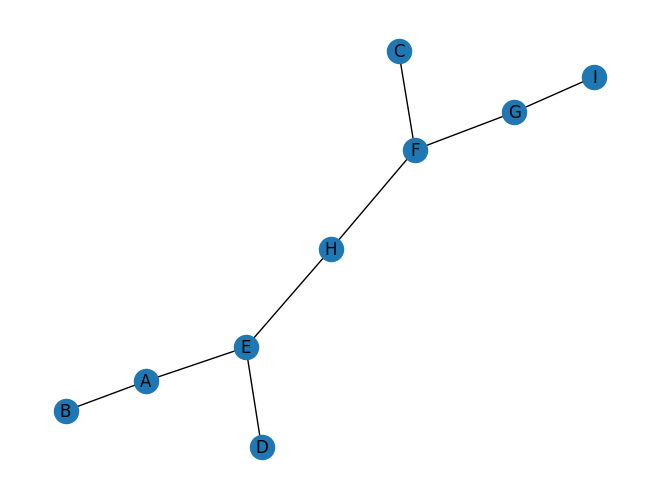

In [23]:
wtree, totalweight = wgraph2.min_spanning_tree()
print(wtree)
print(totalweight)
wtree.plot()

In [24]:
wgraph2.add_edge(["a", "b"], 2)
print(wgraph2)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G
a: b
b: a
------------------------
A: B(3) E(10) 
B: A(3) C(26) D(12) 
E: A(10) D(7) F(8) H(4) 
C: B(26) D(17) F(13) G(14) 
D: B(12) C(17) E(7) F(15) 
F: C(13) D(15) E(8) G(9) H(6) 
G: C(14) F(9) H(16) I(11) 
H: E(4) F(6) G(16) 
I: G(11) 
a: b(2) 
b: a(2) 



In [25]:
wtree, totalweight = wgraph2.min_spanning_tree()
print(wtree)
print(totalweight)

Graph is not connected! Returned is a tree for some connected component.
A: B E
B: A
E: A H D
H: E F
F: H G C
D: E
G: F I
I: G
C: F
------------------------
A: B(3) E(10) 
B: A(3) 
E: A(10) H(4) D(7) 
H: E(4) F(6) 
F: H(6) G(9) C(13) 
D: E(7) 
G: F(9) I(11) 
I: G(11) 
C: F(13) 

63


## Part 5

### Solutions for All Tasks


In [29]:
# Strongly Connected Components (Kosaraju)
print("\n=== Strongly Connected Components Test ===")
scc_graph = Graph()
scc_graph.add_arc([0, 1])
scc_graph.add_arc([1, 2])
scc_graph.add_arc([2, 0])
scc_graph.add_arc([1, 3])
scc_graph.add_arc([3, 4])

print("Graph for SCC:")
print(scc_graph)
print("Strongly Connected Components:")
sccs = scc_graph.StronglyConnectedComponents()
for i, comp in enumerate(sccs):
    print(f"SCC {i+1}: {comp}")



=== Strongly Connected Components Test ===
Graph for SCC:
0: 1
1: 2 3
2: 0
3: 4
4:

Strongly Connected Components:
SCC 1: [0, 2, 1]
SCC 2: [3]
SCC 3: [4]


In [30]:
# Weighted Matrix Conversion and Floyd-Warshall (Weighted)
print("\n=== Weighted Matrix and Floyd-Warshall Test ===")
wg_test = WeightedGraph()
wg_test.add_arc(['A', 'B'], 5)
wg_test.add_arc(['B', 'C'], 10)
wg_test.add_arc(['A', 'C'], 2)

print("Weighted Graph:")
print(wg_test)

print("Converted to Weighted Matrix:")
mat, verts = wg_test.to_weighted_matrix()
print(mat)
print("Vertices:", verts)

print("\nReconstructed from Matrix:")
wg_recon = WeightedGraph.from_weighted_matrix(mat, verts)
print(wg_recon)

print("Floyd-Warshall Distances (Weighted):")
dists, v_order = wg_test.floyd_warshall_weighted()
print("Vertices Order:", v_order)
print(dists)



=== Weighted Matrix and Floyd-Warshall Test ===
Weighted Graph:
A: B C
B: C
C:
------------------------
A: B(5) C(2) 
B: C(10) 
C: 

Converted to Weighted Matrix:
[[ 0.  5.  2.]
 [inf  0. 10.]
 [inf inf  0.]]
Vertices: ['A', 'B', 'C']

Reconstructed from Matrix:
A: B C
B: C
C:
------------------------
A: B(5.0) C(2.0) 
B: C(10.0) 
C: 

Floyd-Warshall Distances (Weighted):
Vertices Order: ['A', 'B', 'C']
[[ 0.  5.  2.]
 [inf  0. 10.]
 [inf inf  0.]]
